Because our Phase 2 results point to the hypothesis of our empirical data not including sufficient dynamical information to be learned by a recurrent neural network, we will in this notebook generate a synthetic dataset built to mimic the qualities of our empirical dataset while being constructed in a way that explicitly has no inter-channel causal dynamics.

To generate this synthetic data we will treat each channel in our data as an independent Poisson process. To generate each channel's new sequence of spikes we will simply take the number of spikes that occurred in that channel originally and change their placement to be uniformly distributed over the interval of sampling time.

# Simulated non-dynamical spike dataset

In [2]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
with open('../pytorch_experiments/binary_spike_matrix_data/all_trial_data_BINNED_715093703_11_30_50.npy', 'rb') as f:
    spikes = np.load(f, allow_pickle=True)

In [3]:
spikes.shape

(487, 131, 2001)

In [10]:
T = spikes.shape[2]
independent_spikes = np.zeros(spikes.shape)

for trial in range(spikes.shape[0]):
    for i in range(spikes.shape[1]):
        new_spike_locations = np.random.choice(T, size=int(sum(spikes[trial,i,:])), replace=False)
        for ind in new_spike_locations:
            independent_spikes[trial, i, ind] = 1

In [11]:
print(sum(spikes.flatten()))
print(sum(independent_spikes.flatten()))

1263171.0
1263171.0


***Saving for our experiment in feeding this data to the RNN***

In [14]:
from datetime import datetime

now = datetime.now()
dt_string = now.strftime("_%H_%M_%S")

with open('../pytorch_experiments/binary_spike_matrix_data/SYNTHETIC_NONDYN_spike_mtx_'+dt_string+'.npy', 'wb') as f:
    np.save(f, independent_spikes)

## Getting the statistics of this dataset so we can compare to the statistics found in the empirical data

### 1) Number of unique vectors

In [15]:
spikes_reshaped = np.transpose(spikes, (0,2,1))
spikes_reshaped = np.reshape(spikes_reshaped, (487*2001, 131))
unique_spikes = np.unique(spikes_reshaped, axis=0)
print('Number unique vectors in Empirical data:',str(unique_spikes.shape[0]))

spikes_reshaped = np.transpose(independent_spikes, (0,2,1))
spikes_reshaped = np.reshape(spikes_reshaped, (487*2001, 131))
unique_spikes = np.unique(spikes_reshaped, axis=0)
print('Number unique vectors in synthetic data:',str(unique_spikes.shape[0]))

Number unique vectors in Empirical data: 113883
Number unique vectors in synthetic data: 109495


### 2) Distribution of zero-block lengths

In [16]:
synthetic_spikes_tsd = np.transpose(independent_spikes, (0,2,1))
print(synthetic_spikes_tsd.shape)

(487, 2001, 131)


In [17]:
zero_block_lens = {}

curr_block_len = 0
for trial in range(synthetic_spikes_tsd.shape[0]):
    for time in range(synthetic_spikes_tsd.shape[1]):
        # when we see a zero vector, accumulate the counter
        if (synthetic_spikes_tsd[trial,time] == np.zeros((131,))).all():
            curr_block_len += 1
        # when we don't, check how long the stretch of zeros before was
        else:
            if curr_block_len > 0:
                if curr_block_len in zero_block_lens.keys():
                    zero_block_lens[curr_block_len] += 1
                else:
                    zero_block_lens[curr_block_len] = 1
                curr_block_len = 0

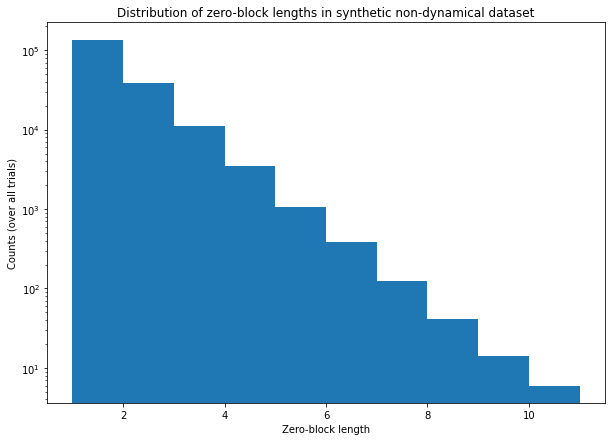

In [19]:
val, weight = zip(*[(k, v) for k,v in zero_block_lens.items()])
plt.figure(figsize=(10,7))
plt.hist(val, weights=weight)
plt.yscale('log')
plt.xlabel('Zero-block length')
plt.ylabel('Counts (over all trials)')
plt.title('Distribution of zero-block lengths in synthetic non-dynamical dataset')
plt.show()

In [20]:
total_zero_vecs = sum([num*leng for (leng, num) in zero_block_lens.items()])
total_zero_vecs

269159

*In the empirical dataset the corresponding number (the total number of zero vectors) was equal to 280592*

Average zero-block length including and not including length-1 blocks:

In [21]:
num_zero_blocks = sum([num for (_, num) in zero_block_lens.items()])
average_zero_block_len = total_zero_vecs/num_zero_blocks
print(average_zero_block_len)

1.4104500293451832


*The number in the empirical data was 1.469*

In [22]:
zero_block_lens_geq2 = zero_block_lens.copy()
zero_block_lens_geq2.pop(1)

avg_zblock_geq2 = sum([num*leng for (leng, num) in zero_block_lens_geq2.items()])\
                    /sum([num for (_, num) in zero_block_lens_geq2.items()])

print(avg_zblock_geq2)

2.4373509010166257


*The number in the empirical data was 2.563*

### 3) Distribution of the number of zero-blocks per trial (for zero-blocks of length > 1)

In [23]:
# the number of zero-blocks will be stored along with the corresponding trial number
zero_blocks_per_trial = {}

num_blocks_in_trial = 0
curr_block_len = 0
for trial in range(synthetic_spikes_tsd.shape[0]):
    for time in range(synthetic_spikes_tsd.shape[1]):
        if (synthetic_spikes_tsd[trial,time] == np.zeros((131,))).all():
            curr_block_len += 1
        else:
            if curr_block_len > 1:
                num_blocks_in_trial += 1
                curr_block_len = 0
    zero_blocks_per_trial[trial] = num_blocks_in_trial
    num_blocks_in_trial = 0

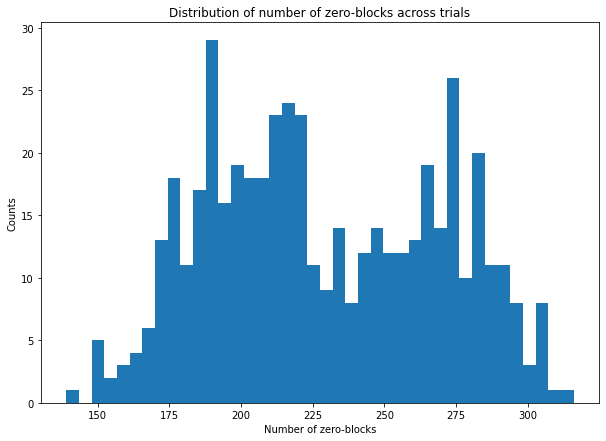

In [24]:
plt.figure(figsize=(10,7))
plt.hist(zero_blocks_per_trial.values(),bins=40)
plt.xlabel('Number of zero-blocks')
plt.ylabel('Counts')
plt.title('Distribution of number of zero-blocks across trials')
plt.show()

*This is the same shape as with the empirical data*

... and the average number per trial:

In [25]:
np.mean(list(zero_blocks_per_trial.values()))

229.0041067761807

*For the empirical data it was 231.72*

### 4) Getting the per-channel interspike time distributions

In [3]:
# loading in the set generated for the model experiments we performed
with open('../pytorch_experiments/binary_spike_matrix_data/SYNTHETIC_NONDYN_spike_mtx__11_32_10.npy', 'rb') as f:
    independent_spikes = np.load(f, allow_pickle=True)

*Below we duplicate the code we used to perform this evaluation on our empirical data – see `allensdk_data_inspection.ipynb`*

In [4]:
# this list will contain 131 lists of interspike times for each channel
interspike_times = []

curr_ist = 0
for nrn in range(independent_spikes.shape[1]):
    # list for this specific neuron's ISTs
    nrn_ists = []
    for trial in range(independent_spikes.shape[0]):
        curr_ist = 0
        for time in range(independent_spikes.shape[2]):
            if independent_spikes[trial,nrn,time] == 0:
                curr_ist += 1
            else:
                if curr_ist > 0:
                    nrn_ists.append(curr_ist)
                    curr_ist = 0
    interspike_times.append(nrn_ists)

In [5]:
# np.histogram gives us the (x,y) tuple of x and y coordinate lists for a given
# neuron's histogram
IST_coordinates = []

for nrn in range(len(interspike_times)):
    hist_points = np.histogram(interspike_times[nrn],bins=100)
    # the numpy hist method gives us the bounds on the histogram bins
    # so we'll calculate the list of midpoints
    bin_middles = [(hist_points[1][i] + hist_points[1][i+1])/2 for i in range(len(hist_points[1]) - 1)]
    IST_coordinates.append((bin_middles, hist_points[0]))

In [6]:
# going to store the normalized curves in a different list
normalized_ISTs = []

for (xs, ys) in IST_coordinates:
    y_max = max(ys)
    # for each curve, want to first normalize the y values
    normalized_ys = ys/y_max
    # then we scale the x axis by the x value where we reach y=1/2
    # --> want to iterate over the xs and store the last index where y>1/2
    for i in range(len(xs)):
        if normalized_ys[i] < 0.5:
            x_half = xs[i-1]
            break
    normalized_xs = xs/x_half
    normalized_ISTs.append((normalized_xs, normalized_ys))

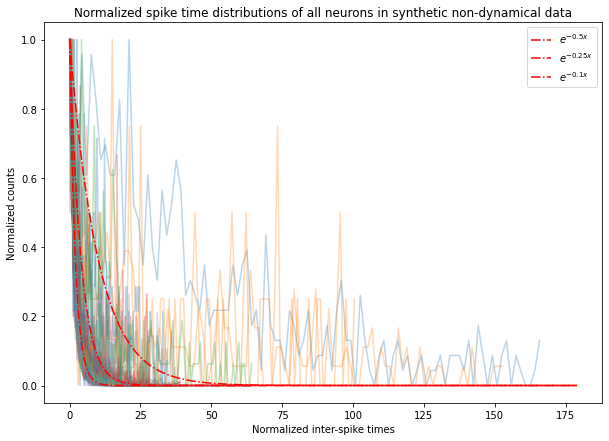

In [7]:
plt.figure(figsize=(10,7))

for (xs,ys) in normalized_ISTs:
        plt.plot(xs, ys, alpha=0.3)

plt.plot(np.arange(180), [np.e**(-0.5*x) for x in np.arange(180)], color='red', linestyle='-.', label=r'$e^{-0.5x}$')
plt.plot(np.arange(180), [np.e**(-0.25*x) for x in np.arange(180)], color='red', linestyle='-.', label=r'$e^{-0.25x}$')
plt.plot(np.arange(180), [np.e**(-0.1*x) for x in np.arange(180)], color='red', linestyle='-.', label=r'$e^{-0.1x}$')

plt.xlabel('Normalized inter-spike times')
plt.ylabel('Normalized counts')
# plt.yscale('log')
plt.title('Normalized spike time distributions of all neurons in synthetic non-dynamical data')
plt.legend()
plt.savefig('../../Summer/Data 2050/Practicum report/figures/nondyn_data_ist_distribution', dpi=300)
plt.show()

*This plot looks very similar to the result we get with the empirical data, except for a couple of curves which show greater counts spread more fully across the range of inter-spike times*